In [1]:
'''
1. Extract spectrograms from wav files
2. Load training images
3. Build autoencoder 
4. Set threshold
5. Make an inference
'''

from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [2]:
'''
Read wav files from SOURCE folder, extract spectrograms in JPG format, and save in TARGET folder
'''

'\nRead wav files from SOURCE folder, extract spectrograms in JPG format, and save in TARGET folder\n'

In [3]:

'''
1. Extract spectrograms from wav files
'''


class SpectrogramExtractor:
    def extract(self, SOURCE, TARGET, FIG_SIZE):
        os.chdir(SOURCE)
        for file in os.listdir(SOURCE):
            # check file extention
            if file.endswith(".wav"):
                # load audio file with Librosa
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    future = executor.submit(librosa.load, file, sr=22050)
                    signal, sample_rate = future.result()

                # perform Fourier transform (FFT -> power spectrum)
                fft = np.fft.fft(signal)

                # calculate abs values on complex numbers to get magnitude
                spectrum = np.abs(fft)

                # create frequency variable
                f = np.linspace(0, sample_rate, len(spectrum))

                # take half of the spectrum and frequency
                left_spectrum = spectrum[:int(len(spectrum)/2)]
                left_f = f[:int(len(spectrum)/2)]

                # STFT -> spectrogram
                hop_length = 512  # in num. of samples
                n_fft = 2048  # window in num. of samples

                # calculate duration hop length and window in seconds
                hop_length_duration = float(hop_length)/sample_rate
                n_fft_duration = float(n_fft)/sample_rate

                # perform stft
                stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

                # calculate abs values on complex numbers to get magnitude
                spectrogram = np.abs(stft)  # np.abs(stft) ** 2

                # apply logarithm to cast amplitude to Decibels
                log_spectrogram = librosa.amplitude_to_db(spectrogram)

                # Matplotlib plots: removing axis, legends and white spaces
                plt.figure(figsize=FIG_SIZE)
                plt.axis('off')
                librosa.display.specshow(
                    log_spectrogram, sr=sample_rate, hop_length=hop_length)
                data_path = pathlib.Path(TARGET)
                file_name = f'{file[0:-4]}.jpg'
                full_name = str(pathlib.Path.joinpath(data_path, file_name))
                plt.savefig(str(full_name), bbox_inches='tight', pad_inches=0)



In [4]:

'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data



In [5]:

'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [6]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    threshold = np.mean(loss) + np.std(loss)
    return threshold


In [7]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss


In [8]:
'''
1. Extract spectrograms from wav files
'''
SOURCE = "C:/data/in"
TARGET = "C:/data/out"
FIG_SIZE = (20, 20)
args = [SOURCE, TARGET, FIG_SIZE]

import time
start = time.perf_counter()

extractor = SpectrogramExtractor()
extractor.extract(SOURCE, TARGET, FIG_SIZE)

finish = time.perf_counter()
print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 0.0 second(s)


In [9]:
'''
2. Load training images
'''
data_path = "C:/data/x_train"
x_train = create_training_data(data_path)

data_path = "C:/data/x_test"
x_test = create_training_data(data_path)

In [10]:
'''
3. Build autoencoder 
'''
autoencoder = Autoencoder(latent_dim=64 * 4)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(x_train, x_train,
						  epochs=10,
						  shuffle=True,
						  validation_data=(x_test, x_test))

Epoch 1/10
1/1 [==============================] - 1s 807ms/step - loss: 0.1122 - val_loss: 0.1134
Epoch 2/10
1/1 [==============================] - 0s 30ms/step - loss: 0.1086 - val_loss: 0.0807
Epoch 3/10
1/1 [==============================] - 0s 28ms/step - loss: 0.0765 - val_loss: 0.0286
Epoch 4/10
1/1 [==============================] - 0s 29ms/step - loss: 0.0287 - val_loss: 0.0151
Epoch 5/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0196 - val_loss: 0.0185
Epoch 6/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0232 - val_loss: 0.0192
Epoch 7/10
1/1 [==============================] - 0s 25ms/step - loss: 0.0230 - val_loss: 0.0194
Epoch 8/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0223 - val_loss: 0.0179
Epoch 9/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0206 - val_loss: 0.0157
Epoch 10/10
1/1 [==============================] - 0s 25ms/step - loss: 0.0186 - val_loss: 0.0145


In [11]:
# a summary of architecture
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
Total params: 12,845,312
Trainable params: 12,845,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 50176)             12895232  
                                                                 
 reshape (Reshape)           (None, 224, 224)          0         
                                                                 
Total params: 12,895,2

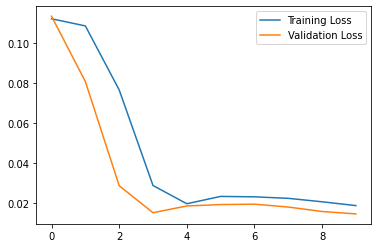

In [12]:
# plot history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [13]:
# save and load a mode
autoencoder.save('./model/')
autoencoder = keras.models.load_model('./model/')

INFO:tensorflow:Assets written to: ./model/assets


In [14]:
# load autoencoder model
if autoencoder is None:
	autoencoder = Autoencoder(latent_dim=64 * 2)
	autoencoder = keras.models.load_model('./model/')

In [15]:
'''
4. Set threshold
'''
threshold = model_threshold(autoencoder, x_train)
# loss = tf.keras.losses.mse(decoded_imgs, x_train)
# threshold = np.mean(loss) + np.std(loss)
print("Loss Threshold: ", threshold)

Loss Threshold:  0.025285822431912085


In [16]:
# load autoencoder model
if autoencoder is None:
	autoencoder = keras.models.load_model('./model/')

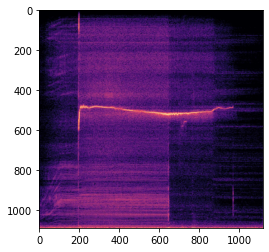

In [23]:
'''
5. Make an inference
'''
# get statistics for each spectrogram
# file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
file = 'c:/data/sample/NOK_121284111NB982000312818.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [24]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

Loss is smaller than threshold 
 		  Sample Loss: 0.01874294877052307 
 		  Threshold: 0.025285822431912085 
